In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [65]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [66]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-09-02 18:37:45--  https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1626269 (1.6M) [text/plain]
Saving to: ‘blp23_sentiment_test_with_label.tsv.1’

blp23_sentiment_tes 100%[===================>]   1.55M  --.-KB/s    in 0.07s   

2023-09-02 18:37:45 (22.1 MB/s) - ‘blp23_sentiment_test_with_label.tsv.1’ saved [1626269/1626269]



In [67]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-09-02 18:37:46--  https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645403 (2.5M) [application/zip]
Saving to: ‘sentiment_analysis_data.zip.1’

sentiment_analysis_ 100%[===================>]   2.52M  --.-KB/s    in 0.08s   

2023-09-02 18:37:46 (31.8 MB/s) - ‘sentiment_analysis_data.zip.1’ saved [2645403/2645403]



In [68]:
!unzip -o /kaggle/working/sentiment_analysis_data.zip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Archive:  /kaggle/working/sentiment_analysis_data.zip
  inflating: blp23_sentiment_dev_test.tsv  
  inflating: blp23_sentiment_dev.tsv  
  inflating: blp23_sentiment_train.tsv  


In [69]:
train_file = '/kaggle/working/blp23_sentiment_train.tsv'
validation_file = '/kaggle/working/blp23_sentiment_dev.tsv'
test_file = '/kaggle/working/blp23_sentiment_dev_test.tsv'

In [70]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

[INFO|training_args.py:1327] 2023-09-02 18:37:47,712 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1769] 2023-09-02 18:37:47,715 >> PyTorch: setting up devices
[INFO|training_args.py:1480] 2023-09-02 18:37:47,719 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [71]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

In [72]:
model_name = 'xlm-roberta-base'

In [73]:
set_seed(training_args.seed)

In [74]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
    return word.split("http")[0].strip()

def extreme_process(word):
    word_list = [word]
    splitter_list = ["**","*", "…", "-"]

    for i in splitter_list:
        if i in word:
            temp_list = word.split(i)
            word_list = list(filter(lambda x:x.strip() != "", temp_list))
            return word_list
    return word_list


def process_word(word):
    word = word.strip()
    if len(word) == 0:
        return []
    elif len(word) == 1:
        if word not in punctuations:
            return [word]
        else:
            return []
    else:
        word = remove_url(word)

        if len(word) == 0:
            return []
        elif len(word) == 1:
            if word in punctuations:
                return []
            else:
                return [word]
        else:
            if word[0] in punctuations:
                word = word[1:]
            if word[-1] in punctuations:
                word = word[:-1]

            word = extreme_process(word)

            return word


In [75]:
l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_df = pd.read_csv(train_file, sep='\t')
print(train_df.head())

               id                                               text     label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...   Neutral
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার   Neutral
2  sentinob_10530      ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন , খুব ই মজার   Positive
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...  Negative
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...  Positive


In [76]:
for index, row in train_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    train_df.at[index, "text"] = " ".join(processed_word_list)

In [77]:
train_df['label'] = train_df['label'].map(l2id)
print(train_df.head())

               id                                               text  label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...      1
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার      1
2  sentinob_10530         ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন খুব ই মজার      2
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...      0
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...      2


In [78]:
train_df = Dataset.from_pandas(train_df)
print(train_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 35266
})


In [79]:
validation_df = pd.read_csv(validation_file, sep='\t')
for index, row in validation_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    validation_df.at[index, "text"] = " ".join(processed_word_list)


In [80]:
validation_df['label'] = validation_df['label'].map(l2id)
validation_df = Dataset.from_pandas(validation_df)
print(validation_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 3934
})


In [81]:
old_test_df = pd.read_csv(test_file, sep='\t')
print(old_test_df.head())
print(len(old_test_df))

      id                                               text
0  30670   * করোনায় আরো ১৮৭ জনের মৃত্যু; মোট প্রাণহানি ...
1   4125          চাপাবাজীর চাপে এবার ধামাচাপা পড়বে আসল ইসু
2  27077   কুয়েতে বাংলাদেশী ফল খেতে হামলে পড়ছেন প্রবাসীরা
3  17552  তিনি ছিলেন টেস্ট খেলা সবচেয়ে বেশি বয়সী জীবিত...
4   4137  চাল আর পাট গুলো উৎপাদন করতে যে কৃষকের বাঁশ ঢুক...
3426


In [82]:
test_df = pd.read_csv("/kaggle/working/blp23_sentiment_test_with_label.tsv", sep="\t")
print(test_df.head())
print(len(test_df))

      id                                               text     label
0   7135  মুখস্ত শিক্ষা দিয়ে কি করবে এই জাতি ? বাংলাদেশ...  Negative
1  28949  জর্ডানের সাবেক যুবরাজ প্রিন্স হামজার ভিডিও বার...  Negative
2  10210  আমার ছেলের দুর্ভাগ্য না সৌভাগ্য জানিনা জ্বর এর...   Neutral
3   9526  Pranoy Sen তখন পাকিস্তান ও আফগানিস্তান ভারতের ...   Neutral
4   2142                              আরো কত মিথ্যাচার করবে  Negative
6707


In [83]:
test_df['label'] = test_df['label'].map(l2id)

In [84]:
for index, row in test_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    test_df.at[index, "text"] = " ".join(processed_word_list)


In [85]:
test_df = Dataset.from_pandas(test_df)
print(test_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 6707
})


In [86]:
data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")

In [87]:
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

In [88]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 35266
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3934
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 6707
    })
})


In [89]:
label_list = raw_datasets["train"].unique("label")
print(label_list)

[1, 2, 0]


In [90]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


In [91]:
num_labels = len(label_list)
print(num_labels)

3


In [92]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

[INFO|configuration_utils.py:715] 2023-09-02 18:37:55,209 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:775] 2023-09-02 18:37:55,215 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_

In [93]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

[INFO|tokenization_auto.py:526] 2023-09-02 18:37:55,284 >> Could not locate the tokenizer configuration file, will try to use the model config instead.
[INFO|configuration_utils.py:715] 2023-09-02 18:37:55,332 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:775] 2023-09-02 18:37:55,335 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id

In [94]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

[INFO|modeling_utils.py:2779] 2023-09-02 18:37:56,302 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
[INFO|modeling_utils.py:3541] 2023-09-02 18:38:05,840 >> Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identic

In [95]:
print(f"Model Name: {model_name}")
print(f"Number of Layers: {config.num_hidden_layers}")
print(f"Hidden Dimension: {config.hidden_size}")
print(f"Number of Attention Heads: {config.num_attention_heads}")
print(f"Intermediate Dimension: {config.intermediate_size}")
print(f"Total Parameters: {model.num_parameters()}")

Model Name: xlm-roberta-base
Number of Layers: 12
Hidden Dimension: 768
Number of Attention Heads: 12
Intermediate Dimension: 3072
Total Parameters: 278045955


In [96]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
print(non_label_column_names)

['id', 'text']


In [97]:
sentence_key= non_label_column_names[1]
print(sentence_key)

text


In [98]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)

In [99]:
if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}

In [100]:
if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")

In [101]:
max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [102]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [103]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/36 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/7 [00:00<?, ?ba/s]

In [104]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [105]:
train_dataset = raw_datasets["train"]
print(train_dataset) 

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 35266
})


In [106]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")

In [107]:
eval_dataset = raw_datasets["validation"]
print(eval_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3934
})


In [108]:
print(max_eval_samples)

None


In [109]:
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

In [110]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")

In [111]:
predict_dataset = raw_datasets["test"]
print(predict_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6707
})


In [112]:
print(max_predict_samples)

None


In [113]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [114]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

In [115]:
metric = evaluate.load("accuracy")

In [116]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

In [117]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    labels = p.label_ids
    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    for label, pred in zip(labels, preds):
        for class_id in range(num_labels):
            if class_id == label and class_id == pred:
                true_positives[class_id] += 1
            elif class_id != label and class_id == pred:
                false_positives[class_id] += 1
            elif class_id == label and class_id != pred:
                false_negatives[class_id] += 1

    return {
        "micro_f1_score": calculate_micro_f1_score(
            list(true_positives.values()), list(false_positives.values()), list(false_negatives.values())
        ),
        "accuracy": (preds == p.label_ids).astype(np.float32).mean().item()
    }


In [118]:
data_collator = default_data_collator

In [119]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [120]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",  # Changed to "steps"
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Perform cross-validation
results = trainer.evaluate()
print(results)

[INFO|training_args.py:1271] 2023-09-02 18:38:14,442 >> using `logging_steps` to initialize `eval_steps` to 500
[INFO|training_args.py:1327] 2023-09-02 18:38:14,444 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1769] 2023-09-02 18:38:14,445 >> PyTorch: setting up devices
[INFO|training_args.py:1480] 2023-09-02 18:38:14,448 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[WARNING|integrations.py:81] 2023-09-02 18:38:14,457 >> Using the `WANDB_DISABLED` environment variable is deprecated and will be removed i

{'eval_loss': 1.128901481628418, 'eval_micro_f1_score': 0.20157600356705604, 'eval_accuracy': 0.20157600939273834, 'eval_runtime': 40.7588, 'eval_samples_per_second': 96.519, 'eval_steps_per_second': 6.036}


In [121]:
train_result = trainer.train()

[INFO|trainer.py:750] 2023-09-02 18:38:56,026 >> The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:1714] 2023-09-02 18:38:56,036 >> ***** Running training *****
[INFO|trainer.py:1715] 2023-09-02 18:38:56,038 >>   Num examples = 35,266
[INFO|trainer.py:1716] 2023-09-02 18:38:56,040 >>   Num Epochs = 3
[INFO|trainer.py:1717] 2023-09-02 18:38:56,041 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:1719] 2023-09-02 18:38:56,043 >>   Training with DataParallel so batch size has been adjusted to: 16
[INFO|trainer.py:1720] 2023-09-02 18:38:56,044 >>   Total train batch size (w. parallel, distributed & accumulation) = 16
[INFO|trainer.py:1721] 2023-09-02 18:38:56,045 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1722] 2023-09-02 18:38

Step,Training Loss,Validation Loss,Micro F1 Score,Accuracy
500,1.058900,1.052202,0.444840,0.444840
1000,1.039800,1.001858,0.527707,0.527707
1500,0.985400,0.923109,0.579054,0.579054
2000,0.922200,0.958219,0.565074,0.565074
2500,0.895200,0.891963,0.607778,0.607778
3000,0.838800,0.878296,0.628622,0.628622
3500,0.840000,0.845451,0.633452,0.633452
4000,0.829800,0.810183,0.646924,0.646924
4500,0.785100,0.847109,0.657855,0.657855
5000,0.757600,0.819014,0.652262,0.652262


[INFO|trainer.py:750] 2023-09-02 18:43:20,320 >> The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-02 18:43:20,324 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-02 18:43:20,325 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-02 18:43:20,327 >>   Batch size = 16
[INFO|trainer.py:2845] 2023-09-02 18:44:00,775 >> Saving model checkpoint to ./output/checkpoint-500
[INFO|configuration_utils.py:460] 2023-09-02 18:44:00,779 >> Configuration saved in ./output/checkpoint-500/config.json
[INFO|modeling_utils.py:1953] 2023-09-02 18:44:03,109 >> Model weights saved in ./output/checkpoint-500/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-02 18:44:03,115 >> tokenizer config file saved in ./output/che

In [122]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [123]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:2845] 2023-09-02 19:48:40,549 >> Saving model checkpoint to ./output
[INFO|configuration_utils.py:460] 2023-09-02 19:48:40,553 >> Configuration saved in ./output/config.json
[INFO|modeling_utils.py:1953] 2023-09-02 19:48:42,882 >> Model weights saved in ./output/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-02 19:48:42,889 >> tokenizer config file saved in ./output/tokenizer_config.json
[INFO|tokenization_utils_base.py:2242] 2023-09-02 19:48:42,893 >> Special tokens file saved in ./output/special_tokens_map.json


***** train metrics *****
  epoch                    =        3.0
  total_flos               =  6481277GF
  train_loss               =     0.8605
  train_runtime            = 1:09:44.44
  train_samples            =      35266
  train_samples_per_second =     25.284
  train_steps_per_second   =      1.581


In [124]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

[INFO|trainer.py:750] 2023-09-02 19:48:44,062 >> The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-02 19:48:44,069 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-02 19:48:44,072 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-02 19:48:44,075 >>   Batch size = 16


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.6579
  eval_loss               =     0.8032
  eval_micro_f1_score     =     0.6579
  eval_runtime            = 0:00:40.78
  eval_samples            =       3934
  eval_samples_per_second =     96.465
  eval_steps_per_second   =      6.032


In [128]:
from sklearn.metrics import accuracy_score
predictions = trainer.predict(predict_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
actual_labels = predict_dataset['label']
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Test Accuracy:", accuracy)

[INFO|trainer.py:750] 2023-09-02 19:57:38,096 >> The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-02 19:57:38,101 >> ***** Running Prediction *****
[INFO|trainer.py:3121] 2023-09-02 19:57:38,103 >>   Num examples = 6707
[INFO|trainer.py:3124] 2023-09-02 19:57:38,105 >>   Batch size = 16
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.6560310123751305


In [133]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


true_labels = predict_dataset["label"]


classification_rep = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:\n", classification_rep)

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
micro_f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

precision = precision_score(true_labels, predicted_labels, average="weighted")  # For binary classification
recall = recall_score(true_labels, predicted_labels, average="weighted")  # For binary classification
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.71      0.76      0.73      3338
     Class 1       0.51      0.26      0.34      1277
     Class 2       0.62      0.74      0.67      2092

    accuracy                           0.66      6707
   macro avg       0.61      0.58      0.58      6707
weighted avg       0.64      0.66      0.64      6707

Macro F1 Score: 0.5830182507501224
Micro F1 Score: 0.6560310123751305
Precision: 0.6427435080949613
Recall: 0.6560310123751305


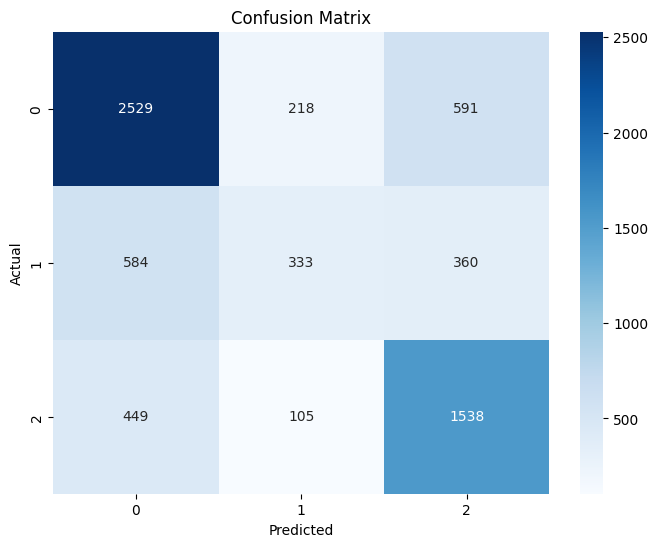

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()